In [1]:
import pandas as pd
import os
from pathlib import Path

PROJECT_ROOT = Path(os.environ["PROJECT_ROOT"])
from auxiliary.static_data import *
from auxiliary.auxiliary_funcs import *
from auxiliary.impute_missing_values import df_new_house_transactions

Added 999 missing rows. Final shape: (6432, 13)


First, create dataframes for each year, with the true and predicted values for each sector. The predicted values are assumed to be the values of the preceding years.

In [2]:
# Add sector_num column for sorting
df_new_house_transactions["sector_num"] = (
    df_new_house_transactions["sector"].str.extract("(\d+)").astype(int)
)

# Create y_true arrays for each time period
time_periods = [
    ("2019", 2019),
    ("2020", 2020),
    ("2021", 2021),
    ("2022", 2022),
    ("2023", 2023),
]

for period_name, true_yr in time_periods:
    # Get true values (current year: Aug to July)
    # df_true_2020 refers to the year that starts in August 2020 and ends in July 2021
    mask_true = (
        (df_new_house_transactions["yr"] == true_yr)
        & (df_new_house_transactions["m"] >= 8)
    ) | (
        (df_new_house_transactions["yr"] == true_yr + 1)
        & (df_new_house_transactions["m"] <= 7)
    )

    df_true = df_new_house_transactions[mask_true]

    exec(
        f"df_true_{period_name} = df_true[['new_house_transaction_amount', 'm', 'yr', 'sector_num']].reset_index(drop=True)"
    )

Now let us obtain the predictions

In [3]:
import statsmodels.api as sm

# baseline prediciton is same as last year
df_pred_2020 = df_true_2019.copy()
df_pred_2020["yr"] = df_pred_2020["yr"] + 1

df_pred_2021 = df_true_2020.copy()
df_pred_2021["yr"] = df_pred_2021["yr"] + 1

df_pred_2022 = df_true_2021.copy()
df_pred_2022["yr"] = df_pred_2022["yr"] + 1

df_pred_2023 = df_true_2022.copy()
df_pred_2023["yr"] = df_pred_2023["yr"] + 1

df_pred_2024 = df_true_2023.copy()
df_pred_2024["yr"] = df_pred_2024["yr"] + 1


df_pred_list = [df_pred_2020, df_pred_2021, df_pred_2022, df_pred_2023, df_pred_2024]
for df_pred in df_pred_list:
    for sector in range(1, 97):
        # do OLS on df_lag to obtain the coefficients

        Y = (
            df_pred.loc[df_pred["sector_num"] == sector]["new_house_transaction_amount"]
            .iloc[1:]
            .values
        )
        Xlag = (
            df_pred.loc[df_pred["sector_num"] == sector]["new_house_transaction_amount"]
            .shift(1)
            .iloc[1:]
            .values
        )
        Xmat = sm.add_constant(Xlag)
        ols = sm.OLS(Y, Xmat).fit()
        a, b = ols.params

        # then use the coefficients to predict the values of df_pred
        x0 = df_pred.loc[
            df_pred["sector_num"] == sector, "new_house_transaction_amount"
        ].iloc[-1]
        predictions = []
        for i in range(12):
            predictions.append(a + b * x0)
            x0 = a + b * x0
        df_pred.loc[
            df_pred["sector_num"] == sector, "new_house_transaction_amount"
        ] = predictions

use a multiplicative factor to adjust the predicted values

In [4]:
y_preds = [
    df_pred_2020["new_house_transaction_amount"].to_numpy(),
    df_pred_2021["new_house_transaction_amount"].to_numpy(),
    df_pred_2022["new_house_transaction_amount"].to_numpy(),
    df_pred_2023["new_house_transaction_amount"].to_numpy(),
]

y_trues = [
    df_true_2020["new_house_transaction_amount"].to_numpy(),
    df_true_2021["new_house_transaction_amount"].to_numpy(),
    df_true_2022["new_house_transaction_amount"].to_numpy(),
    df_true_2023["new_house_transaction_amount"].to_numpy(),
]

multiplicative_factor = 0.75

years_of_prediction = [2020, 2021, 2022, 2023]

print(f"Multiplicative factor: {multiplicative_factor}")
for y_pred, y_true, year in zip(y_preds, y_trues, years_of_prediction):
    print(f"Year: {year}")
    print(
        f"Score: {random_half_score(multiplicative_factor*y_pred, y_true,  n_repeats= 1152*4)}"
    )

Multiplicative factor: 0.75
Year: 2020
Score: 0.39661577296290673
Year: 2021
Score: 0.0
Year: 2022
Score: 0.2659767771211136
Year: 2023
Score: 0.5143310072798397


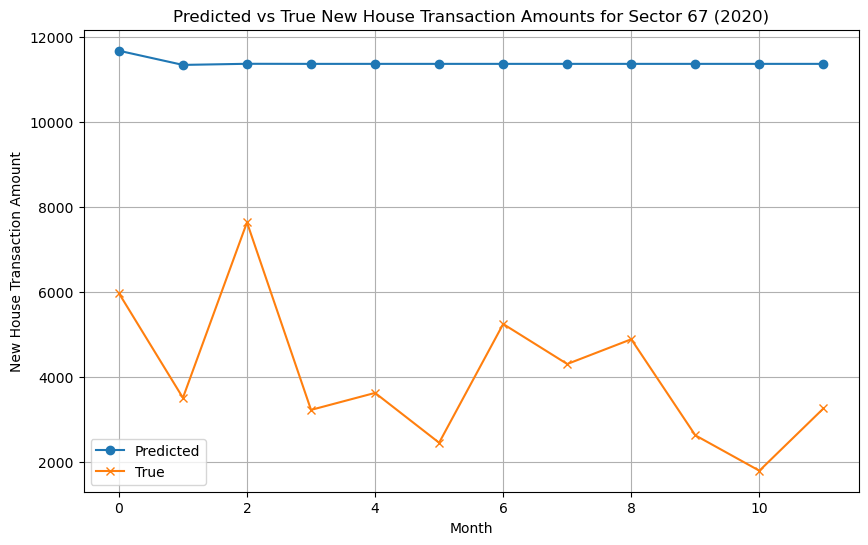

In [5]:
sector = 67
df_to_plot = df_pred_2022.copy()
df_to_plot_true = df_true_2022.copy()

y_pred = df_to_plot.loc[
    df_to_plot["sector_num"] == sector, "new_house_transaction_amount"
]
y_true = df_to_plot_true.loc[
    df_to_plot_true["sector_num"] == sector, "new_house_transaction_amount"
]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_pred.values, label="Predicted", marker="o")
plt.plot(y_true.values, label="True", marker="x")
plt.title(f"Predicted vs True New House Transaction Amounts for Sector {sector} (2020)")
plt.xlabel("Month")
plt.ylabel("New House Transaction Amount")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
df_to_submit = df_pred_2024.copy()
df_to_submit["new_house_transaction_amount"] = (
    df_pred_2024["new_house_transaction_amount"] * 0.75
)

df_to_submit["id"] = df_to_submit.apply(
    lambda row: f"{int(row['yr'])} {int_to_month[row['m']]}_sector {int(row['sector_num'])}",
    axis=1,
)

df_to_submit = df_to_submit.drop(columns=["yr", "m", "sector_num"], axis=1)

df_to_submit = df_to_submit[["id", "new_house_transaction_amount"]]

csv_path = PROJECT_ROOT / "submissions" / "baseline_submission_autocorrelation.csv"
df_to_submit.to_csv(csv_path, index=False)